
# Experiment 1: Baseline Model


#### Helper Functions

In [1]:
# finding accuracy 
def accuracy_score(outputs, targets, batch_size):
    out = output_to_guess(outputs, 0.5)
    numCorrect = int(torch.sum(torch.sum((out == targets), dim=1)))
    total = batch_size * 14
    return numCorrect / total


#helper function to convert a network output to a guess
def output_to_guess(output, cutoff):
    # create a temporary tensor to not override original
    temp = output.clone()
    temp[output >= 0.5] = 1
    temp[output < 0.5] = 0
    return temp

# printing performce of model
def printModelPerformance(performanceList):
    accuracy_list = []
    precision_list = []
    recall_list = []
    bcr_list = []
    for i in range(len(performanceList)):
        ac, pre, re, bcr = printSingleStat(performanceList, i)
        accuracy_list.append(ac)
        precision_list.append(pre)
        recall_list.append(re)
        bcr_list.append(bcr)
    print("Model Average Performece")
    print("Accuracy: ", round((sum(accuracy_list) / len(accuracy_list)), 3))
    print("Precision: ", round((sum(precision_list) / len(precision_list)), 3))
    print("Recall: ", round((sum(recall_list) / len(recall_list)), 3))
    print("BCR: ", round((sum(bcr_list) / len(bcr_list)),3))
    
def printSingleStat(performanceList, index):
    disease = test_loader.dataset.classes[index]
    TP = p_r_list[index]["TP"]
    FP = p_r_list[index]["FP"]
    TN = p_r_list[index]["TN"]
    FN = p_r_list[index]["FN"]
    
    Acc = (TN + TP) / (TP + TN + FP + FN)
    if ((FP + TP) == 0):
        Precision = 0
    else:
        Precision = (TP) / (FP + TP)
    if ((TP + FN) == 0):
        Recall = 0
    else:
        Recall = (TP) / (TP + FN)
    BCR = (Precision + Recall) / 2
    print("Disease: ", disease)
    print("Accuracy: ", round(Acc,3))
    print("Precision: ", round(Precision,3))
    print("Recall: ", round(Recall,3))
    print("BCR: ", round(BCR,3))
    
    return Acc, Precision, Recall, BCR

## Creating the Model

In [2]:
from baseline_cnn import *
from baseline_cnn import BasicCNN
from copy import deepcopy


# Setup: initialize the hyperparameters/variables
num_epochs = 1           # Number of full passes through the dataset
batch_size = 32        # Number of samples in each minibatch
learning_rate = 0.00001  
seed = np.random.seed(1) # Seed the random number generator for reproducibility
p_val = 0.1              # Percent of the overall dataset to reserve for validation
p_test = 0.2             # Percent of the overall dataset to reserve for testing

#TODO: Convert to Tensor - you can later add other transformations, such as Scaling here
#transform = transforms.Compose(______) #starter codse
transform = transforms.Compose([transforms.Resize((512,512)), transforms.ToTensor()])


# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

# Setup the training, validation, and testing dataloaders
train_loader, val_loader, test_loader = create_split_loaders(batch_size, seed, transform=transform, 
                                                             p_val=p_val, p_test=p_test,
                                                             shuffle=True, show_sample=False, 
                                                             extras=extras)

# Instantiate a BasicCNN to run on the GPU or CPU based on CUDA support
model = BasicCNN()
model = model.to(computing_device)
print("Model on CUDA?", next(model.parameters()).is_cuda)

#TODO: Define the loss criterion and instantiate the gradient descent optimizer
#criterion = ______ #TODO - loss criteria are defined in the torch.nn package
criterion = torch.nn.BCELoss(size_average = True)
#TODO: change loss function to weighted loss

#TODO: Instantiate the gradient descent optimizer - use Adam optimizer with default parameters
#optimizer = ______ #TODO - optimizers are defined in the torch.optim package #this is the start code line
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)

CUDA is supported
Model on CUDA? True


## Training the Model

In [3]:
# Track the loss across training
total_loss = []
avg_minibatch_loss = []
all_valid_loss = []
train_accuracies = []
val_accuracies = []
best_model = model

# Begin training procedure
for epoch in range(num_epochs):

    N = 50
    Validation_N = 250
    N_minibatch_loss = 0.0
    N_minibatch_accuracy = 0.0

    # Get the next minibatch of images, labels for training
    for minibatch_count, (images, labels) in enumerate(train_loader, 0):
        

        # Put the minibatch data in CUDA Tensors and run on the GPU if supported
        images, labels = images.to(computing_device), labels.to(computing_device)
        
        # Zero out the stored gradient (buffer) from the previous iteration
        optimizer.zero_grad()

        # Perform the forward pass through the network and compute the loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        accuracy = accuracy_score(outputs, labels, batch_size)
        
        # Automagically compute the gradients and backpropagate the loss through the network
        loss.backward()

        # Update the weights
        optimizer.step()

        # Add this iteration's loss to the total_loss
        total_loss.append(loss.item())
        N_minibatch_loss += loss
        N_minibatch_accuracy += accuracy
        
            
        if (minibatch_count % N == 0) & (minibatch_count > 0):    
            
            # Print the loss averaged over the last N mini-batches    
            N_minibatch_loss /= N
            N_minibatch_accuracy /= N
            print('Epoch %d, average minibatch %d loss: %.3f' %
                (epoch + 1, minibatch_count, N_minibatch_loss))
            
            # Add the averaged loss over N minibatches and reset the counter
            avg_minibatch_loss.append(N_minibatch_loss)
            print("accuracy", N_minibatch_accuracy)
            train_accuracies.append(N_minibatch_accuracy)
            N_minibatch_loss = 0.0
            N_minibatch_accuracy = 0.0
            
            
        if (minibatch_count % Validation_N == 0) & (minibatch_count > 0):    
            val_loss = 0
            accuracy = 0
            with torch.no_grad(): 
                for minibatch_count, (images, labels) in enumerate(val_loader, 0):
                    # Put the minibatch data in CUDA Tensors and run on the GPU if supported
                    images, labels = images.to(computing_device), labels.to(computing_device)
                    
                    outputs = model(images)
                    val_loss += criterion(outputs, labels)
                    accuracy += accuracy_score(outputs, labels, batch_size)
                
                avgLoss = val_loss / minibatch_count
                valAccuracy = accuracy / minibatch_count
                
                print("Val Loss", avgLoss.item())
                print("Accuracy", valAccuracy)
                #checks if model is best model so far
                if (len(all_valid_loss) == 0):
                    model = deepcopy(model)
                else:
                    if (avgLoss.item() < min(all_valid_loss)):
                        model = deepcopy(model)
                all_valid_loss.append(avgLoss.item())
                val_accuracies.append(valAccuracy)

    print("Finished", epoch + 1, "epochs of training")
print("Training complete after", epoch + 1, "epochs")

Epoch 1, average minibatch 50 loss: 0.233
accuracy 0.9513392857142857
Epoch 1, average minibatch 100 loss: 0.193
accuracy 0.9459375000000001
Epoch 1, average minibatch 150 loss: 0.177
accuracy 0.9512053571428569
Epoch 1, average minibatch 200 loss: 0.186
accuracy 0.9470982142857143
Epoch 1, average minibatch 250 loss: 0.183
accuracy 0.9469196428571428
Val Loss 0.18417401611804962
Accuracy 0.9491071428571423
Epoch 1, average minibatch 300 loss: 0.170
accuracy 0.9530357142857145
Epoch 1, average minibatch 350 loss: 0.183
accuracy 0.9481696428571427
Epoch 1, average minibatch 400 loss: 0.187
accuracy 0.9474107142857144
Epoch 1, average minibatch 450 loss: 0.185
accuracy 0.9475892857142857
Epoch 1, average minibatch 500 loss: 0.182
accuracy 0.9485714285714283
Val Loss 0.18402986228466034
Accuracy 0.9491071428571425
Epoch 1, average minibatch 550 loss: 0.179
accuracy 0.9501785714285715
Epoch 1, average minibatch 600 loss: 0.185
accuracy 0.9482589285714286
Epoch 1, average minibatch 650 loss

## Plotting Training

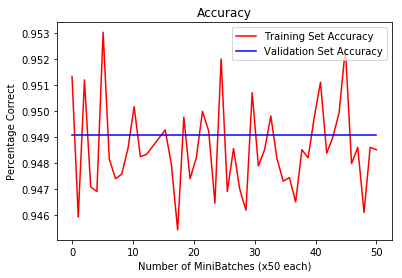

In [4]:
#Accuracy plotting

x1 = np.linspace(0,50,50)
x2 = np.linspace(0,50,10)

plt.plot(x1, train_accuracies, color = "red",label = "Training Set Accuracy")
plt.plot(x2, val_accuracies, color = "blue",label = "Validation Set Accuracy")
plt.xlabel("Number of MiniBatches (x50 each)")
plt.ylabel("Percentage Correct")
plt.title("Accuracy")
plt.legend(loc='upper right')
plt.show()

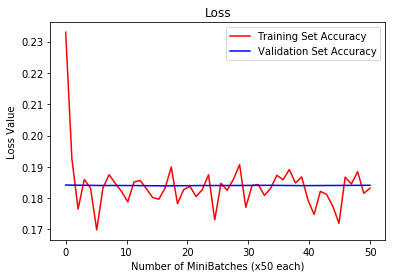

In [5]:
#Loss Function plotting

x1 = np.linspace(0,50,50)
x2 = np.linspace(0,50,10)

plt.plot(x1, avg_minibatch_loss, color = "red",label = "Training Set Accuracy")
plt.plot(x2, all_valid_loss, color = "blue",label = "Validation Set Accuracy")
plt.xlabel("Number of MiniBatches (x50 each)")
plt.ylabel("Loss Value")
plt.title("Loss")
plt.legend(loc='upper right')
plt.show()


### Convolutional Layer 1 Filters

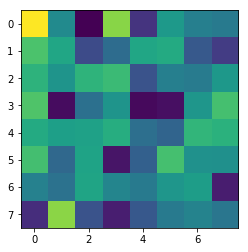

In [6]:
x = (best_model.conv1.weight.cpu().data.numpy()[3])[0]
plt.imshow(x)

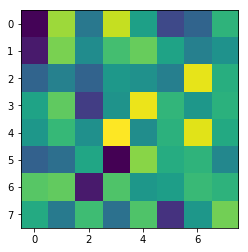

In [7]:
y = (best_model.conv1.weight.cpu().data.numpy()[2])[0]
plt.imshow(y)

### Convolutional Layer 2 Filters

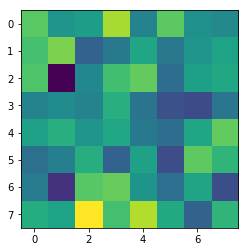

In [8]:
x = (best_model.conv2.weight.cpu().data.numpy()[3])[0]
plt.imshow(x)

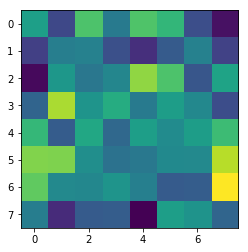

In [9]:
y = (best_model.conv2.weight.cpu().data.numpy()[8])[0]
plt.imshow(y)

### Convolutional Layer 3 Filters

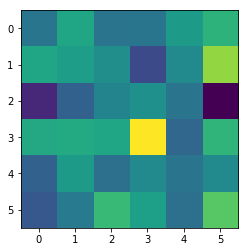

In [10]:
x = (best_model.conv3.weight.cpu().data.numpy()[3])[0]
plt.imshow(x)

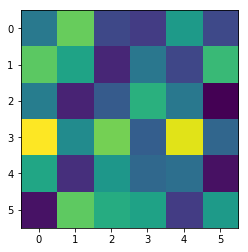

In [11]:
y = (best_model.conv3.weight.cpu().data.numpy()[0])[0]
plt.imshow(y)

## Testing Model Performance

In [12]:
#test based on best_model variable


p_r_list = []    #list of dictionaries, where each dictionary contains 'TP', 'FP', 'TN', 'FN'

for i in range(14):
    p_r_list.append({'TP': 0, 'FP': 0, 'TN': 0, 'FN': 0})

c_matrix = []     # confusion matrix

for i in range(14):
    c_matrix.append([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

for minibatch_count, (images, labels) in enumerate(test_loader, 0):
    
    print("current minibatch: ", minibatch_count)
    # Put the minibatch data in CUDA Tensors and run on the GPU if supported
    images, labels = images.to(computing_device), labels.to(computing_device)
    
    outputs = model(images)
    outputs = output_to_guess(outputs, 0.5)
    with torch.no_grad():
        for i in range(outputs.shape[0]):
            out = outputs.split(1)[i].tolist()[0]    # convert the outputs from tensor object to a list
            lab = labels.split(1)[i].tolist()[0]     # convert the labels from tensor object to a list

            for j in range(14):
                if out[j] == 1 and lab[j] == 1:
                    p_r_list[j]['TP'] += 1
                elif out[j] == 1 and lab[j] == 0:
                    p_r_list[j]['FP'] += 1
                elif out[j] == 0 and lab[j] == 0:
                    p_r_list[j]['TN'] += 1
                else:
                    p_r_list[j]['FN'] += 1

            for k in range(14):
                if (out[k] == 1 and lab[k] == 1) or (out[k] == 1 and lab[k] == 1):     # if output == label, put a 1 at (k,k) and zeros for everything else in that row
                    c_matrix[k][k] += 1
                if out[k] == 1 and lab[k] == 0:   # if output = 1 and label = 0, evenly distribute the error amongst activated outputs (where out[k] == 1)
                    sum_of_out = sum(out)
                    for a in range(14):
                        if out[a] == 1:
                            c_matrix[k][a] += 1/sum_of_out
                if out[k] == 0 and lab[k] == 1:   # if output = 0 and label = 1, put zeros for the row (it's not confused with other classes)
                    continue

for x in range(len(c_matrix)):
    row_sum = sum(c_matrix[x])
    if (row_sum != 0):
        for y in range(14):
            c_matrix[x][y] = c_matrix[x][y] / row_sum


    

current minibatch:  0
current minibatch:  1
current minibatch:  2
current minibatch:  3
current minibatch:  4
current minibatch:  5
current minibatch:  6
current minibatch:  7
current minibatch:  8
current minibatch:  9
current minibatch:  10
current minibatch:  11
current minibatch:  12
current minibatch:  13
current minibatch:  14
current minibatch:  15
current minibatch:  16
current minibatch:  17
current minibatch:  18
current minibatch:  19
current minibatch:  20
current minibatch:  21
current minibatch:  22
current minibatch:  23
current minibatch:  24
current minibatch:  25
current minibatch:  26
current minibatch:  27
current minibatch:  28
current minibatch:  29
current minibatch:  30
current minibatch:  31
current minibatch:  32
current minibatch:  33
current minibatch:  34
current minibatch:  35
current minibatch:  36
current minibatch:  37
current minibatch:  38
current minibatch:  39
current minibatch:  40
current minibatch:  41
current minibatch:  42
current minibatch:  4

current minibatch:  346
current minibatch:  347
current minibatch:  348
current minibatch:  349
current minibatch:  350
current minibatch:  351
current minibatch:  352
current minibatch:  353
current minibatch:  354
current minibatch:  355
current minibatch:  356
current minibatch:  357
current minibatch:  358
current minibatch:  359
current minibatch:  360
current minibatch:  361
current minibatch:  362
current minibatch:  363
current minibatch:  364
current minibatch:  365
current minibatch:  366
current minibatch:  367
current minibatch:  368
current minibatch:  369
current minibatch:  370
current minibatch:  371
current minibatch:  372
current minibatch:  373
current minibatch:  374
current minibatch:  375
current minibatch:  376
current minibatch:  377
current minibatch:  378
current minibatch:  379
current minibatch:  380
current minibatch:  381
current minibatch:  382
current minibatch:  383
current minibatch:  384
current minibatch:  385
current minibatch:  386
current minibatc

### Model Statistics

In [14]:
printModelPerformance(p_r_list)

Disease:  Atelectasis
Accuracy:  0.896
Precision:  0.5
Recall:  0.0
BCR:  0.25
Disease:  Cardiomegaly
Accuracy:  0.976
Precision:  0.5
Recall:  0.002
BCR:  0.251
Disease:  Effusion
Accuracy:  0.881
Precision:  0.5
Recall:  0.0
BCR:  0.25
Disease:  Infiltration
Accuracy:  0.82
Precision:  0.667
Recall:  0.001
BCR:  0.334
Disease:  Mass
Accuracy:  0.95
Precision:  0.5
Recall:  0.001
BCR:  0.25
Disease:  Nodule
Accuracy:  0.941
Precision:  0.5
Recall:  0.001
BCR:  0.25
Disease:  Pneumonia
Accuracy:  0.986
Precision:  0.5
Recall:  0.004
BCR:  0.252
Disease:  Pneumothorax
Accuracy:  0.953
Precision:  0.333
Recall:  0.001
BCR:  0.167
Disease:  Consolidation
Accuracy:  0.958
Precision:  0.5
Recall:  0.001
BCR:  0.251
Disease:  Edema
Accuracy:  0.979
Precision:  0.5
Recall:  0.002
BCR:  0.251
Disease:  Emphysema
Accuracy:  0.977
Precision:  0.5
Recall:  0.002
BCR:  0.251
Disease:  Fibrosis
Accuracy:  0.986
Precision:  0.5
Recall:  0.003
BCR:  0.252
Disease:  Pleural_Thickening
Accuracy:  0.97


### Confusion Matrix

In [15]:
#print confusion matrix

for i in c_matrix:
    a = ['%.2f' % elem for elem in i]
    print(a)

['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.00', '0.00', '1.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '1.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00',